In [1]:
# For tips on running notebooks in Google Colab, see
# https://pytorch.org/tutorials/beginner/colab
%matplotlib inline

In [2]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 35.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38262 sha256=4ea13e0fd69a6fb2a2e1c9f37292c15439c0671de99008beb0cd1d5f3da3ae51
  Stored in directory: /root/.cache/pip/wheels/3c/6c/04/9a543775e9f25f6c441180a552456f1696167439459730ff87
Successfully built grad-cam


In [3]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

cudnn.benchmark = True
plt.ion()   # interactive mode

## Load Data

.. Note ::
   Download the data from
   [here](https://download.pytorch.org/tutorial/hymenoptera_data.zip)
   and extract it to the current directory. -->
Download this dataset and upload to google drive



In [4]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = '/content/drive/MyDrive/hymenoptera_data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Visualize a few images
Let's visualize a few training images so as to understand the data
augmentations.



(3, 228, 906)
(228, 906, 3)
(228, 906, 3)
(228, 906, 3)


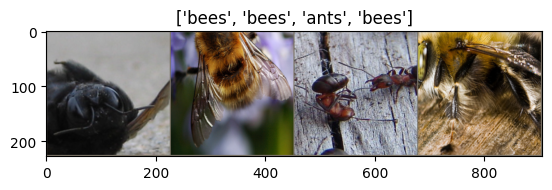

In [6]:
def imshow(inp, title=None):
    print(inp.numpy().shape)
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    print(inp.shape)
    inp = np.clip(inp, 0, 1)
    print(inp.shape)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

## Training the model

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



In [7]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

### Visualizing the model predictions

Generic function to display predictions for a few images




In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

## Finetuning the ConvNet

Load a pretrained model and reset final fully connected layer.




In [9]:
model_ft = models.resnet152(weights='IMAGENET1K_V2')
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(class_names))``.
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:02<00:00, 104MB/s]


In [10]:
'''
Test Swin Transoformer Performance

model_ft = models.swin_v2_b(weights='IMAGENET1K_V1')
num_ftrs = model_ft.head.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft.head = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, 2)
)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

optimizer_ft = optim.AdamW(model_ft.head.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.97)
'''

"\nTest Swin Transoformer Performance\n\nmodel_ft = models.swin_v2_b(weights='IMAGENET1K_V1')\nnum_ftrs = model_ft.head.in_features\n#model_ft.fc = nn.Linear(num_ftrs, 2)\n\nmodel_ft.head = nn.Sequential(\n    nn.Linear(num_ftrs, 512),\n    nn.ReLU(),\n    nn.Dropout(0.3),\n    nn.Linear(512, 2)\n)\n\nmodel_ft = model_ft.to(device)\n\ncriterion = nn.CrossEntropyLoss()\n\n# Observe that all parameters are being optimized\n#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)\n\n# Decay LR by a factor of 0.1 every 7 epochs\n#exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)\n\noptimizer_ft = optim.AdamW(model_ft.head.parameters(), lr=0.001)\nexp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=3, gamma=0.97)\n"

### Train and evaluate

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5814 Acc: 0.6680
val Loss: 0.3506 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.3309 Acc: 0.8607
val Loss: 0.2013 Acc: 0.9608

Epoch 2/24
----------
train Loss: 0.2740 Acc: 0.8770
val Loss: 0.1590 Acc: 0.9869

Epoch 3/24
----------
train Loss: 0.2851 Acc: 0.8566
val Loss: 0.1362 Acc: 0.9869

Epoch 4/24
----------
train Loss: 0.2713 Acc: 0.8811
val Loss: 0.1526 Acc: 0.9673

Epoch 5/24
----------
train Loss: 0.2349 Acc: 0.8852
val Loss: 0.1222 Acc: 0.9935

Epoch 6/24
----------
train Loss: 0.2260 Acc: 0.8893
val Loss: 0.1126 Acc: 0.9739

Epoch 7/24
----------
train Loss: 0.1844 Acc: 0.9344
val Loss: 0.1186 Acc: 0.9673

Epoch 8/24
----------
train Loss: 0.1685 Acc: 0.9426
val Loss: 0.1199 Acc: 0.9869

Epoch 9/24
----------
train Loss: 0.1669 Acc: 0.9426
val Loss: 0.1113 Acc: 0.9869

Epoch 10/24
----------
train Loss: 0.1953 Acc: 0.9180
val Loss: 0.1181 Acc: 0.9673

Epoch 11/24
----------
train Loss: 0.1911 Acc: 0.9344
val Loss: 0.1117 Acc: 0.9542

Ep

In [ ]:
#gradcam imports
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import cv2

In [ ]:
#create an input tensor (image to gradcam)
imgtransform = transforms.Compose([
       transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
   ])

iptimage=Image.open("/content/drive/MyDrive/hymenoptera_data/hymenoptera_data/train/bees/1092977343_cb42b38d62.jpg")
img_np = np.array(iptimage)
img_resized = cv2.resize(img_np, (224, 224))
img_np = np.array(img_resized).astype(np.float32) / 255.0


input_tensor = imgtransform(iptimage)
input_tensor = input_tensor.unsqueeze(0) #add batch dimension

In [ ]:
# Target layers for Resnet152
target_layers = [model_ft.layer4[-1]]


# Target layers for SwinT
#target_layers = [model_ft.layers[-1].blocks[-1].norm1]
#target_layers = [model_ft.features[0][-1]]
#print(model_ft.features[-1][0].norm1)
#target_layers = [model_ft.features[-1][-1].norm1]


# Construct the CAM object once, and then re-use it on many images:
cam = GradCAMPlusPlus(model=model_ft, target_layers=target_layers, use_cuda=True)

# You can also use it within a with statement, to make sure it is freed,
# In case you need to re-create it inside an outer loop:
# with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
#   ...

# We have to specify the target we want to generate
# the Class Activation Maps for.
# If targets is None, the highest scoring category
# will be used for every image in the batch.
# Here we use ClassifierOutputTarget, but you can define your own custom targets
# That are, for example, combinations of categories, or specific outputs in a non standard model.

targets = [ClassifierOutputTarget(0)]

# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, targets=targets)

# In this example grayscale_cam has only one image in the batch:
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)
Image.fromarray(visualization)


In [ ]:
!pip install torcheval
!pip install torchmetrics

Img tensor:  tensor([0.0039, 0.0039, 0.0039,  ..., 0.0016, 0.0016, 0.0016])
tensor(0.1246)
tensor([0.2007, 0.2004, 0.2002,  ..., 0.0000, 0.0000, 1.0000])
tensor([1.0000, 0.9984, 0.9968,  ..., 0.0000, 0.0000, 0.0000])


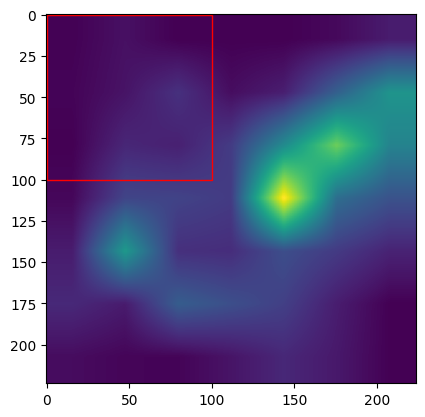

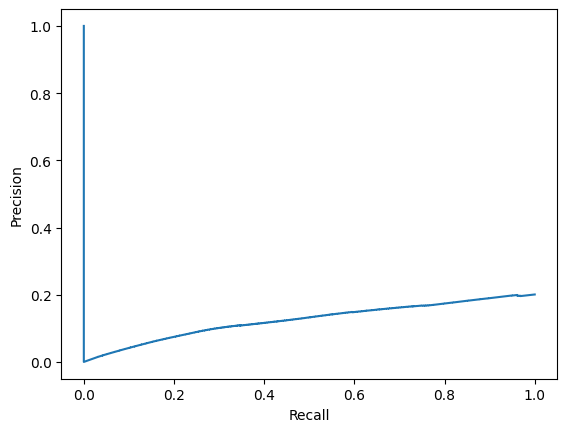

In [16]:
import matplotlib.patches as patches
import random
from torcheval.metrics.functional import binary_auprc
from torchmetrics import PrecisionRecallCurve

fig, ax = plt.subplots()

# Generate a random bounding box to compute intersecting areas
def generate_random_bbox(img):
    height = np.array(img).shape[0]
    width = np.array(img).shape[1]

    x = int(random.random() * width)
    x2 = int(random.random() * width)
    y = int(random.random() * height)
    y2 = int(random.random() * height)

    x_anchor = min(x, x2)
    w = abs(x - x2)

    y_anchor = min(y, y2)
    h = abs(y - y2)

    # Or, generate a set bounding box for testing
    y_anchor = 0
    x_anchor = 0
    w = 100
    h = 100

    rect = patches.Rectangle((x_anchor, y_anchor), w, h, linewidth=1, edgecolor='r', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(rect)

    data = np.zeros((np.array(img).shape[0], np.array(img).shape[1]), dtype=int)
    for i in range(y_anchor, y_anchor + h):
        for j in range(x_anchor, x_anchor + w):
            data[i][j] = 1
    return data

# Binary mask

#binary_img = np.where(grayscale_cam >= 0.5, 1, grayscale_cam)
#binary_img = np.where(binary_img < 0.5, 0, binary_img)

#ax.imshow(binary_img)
ax.imshow(grayscale_cam)

bbox_data = generate_random_bbox(img_resized)
#ax.imshow(bbox_data)

bbox_tensor = torch.tensor(bbox_data.flatten())
#img_tensor = torch.tensor(grayscale_cam.flatten())
img_tensor = torch.tensor(grayscale_cam.flatten())

print("Img tensor: ", img_tensor)
auprc = binary_auprc(img_tensor, bbox_tensor)

print(auprc)

pr_curve = PrecisionRecallCurve(task="binary")
precision, recall, thresholds = pr_curve(img_tensor, bbox_tensor)

print(precision)
print(recall)

plt.show()

plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


